# 2020 Election Simulator

### First Attempt - Bayesian Inference
Aggregation of normal distributions assuming they are independent and identically distributed.  Bayesian inference used to compute posterior mean and variance for a given prior and likelihood function.

$Prior  \newline \quad \quad
    f_1(x) = \frac{1}{\sigma_1\sqrt{2\pi}}e{\frac{-(x-\mu_1)^2}{2\sigma_1^2}}$

$Likelihood  \newline \quad \quad
    f_2(x) = \frac{1}{\sigma_2\sqrt{2\pi}}e{\frac{-(x-\mu_2)^2}{2\sigma_2^2}}$

$Posterior Mean  \newline \quad \quad
    \mu = \frac{\frac{\mu_1}{2\sigma_1^2}+\frac{\mu_2}{2\sigma_2^2}}{\frac{1}{2\sigma_1^2}+\frac{1}{2\sigma_2^2}} = 
    \frac{\mu_1\sigma_2^2+\mu_2\sigma_1^2}{\sigma_2^2+\sigma_1^2}$

$Posterior Variance  \newline \quad \quad
    \sigma^2 = \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}} = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}$

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import polling data
df = pd.read_csv('data.csv', encoding='cp1252')#, index_col = 0)

# dictionary of Electoral College Votes
EC = {  'AK':3, 'AL':9, 'AR':6, 'AZ':11, 'CA':55, 'CO': 9, 'CT':7, 'DE':3, 'FL':29, 'GA':16, \
        'HI':4, 'IA':6, 'ID':4, 'IL':20, 'IN':11, 'KS':6, 'KY':8, 'LA':8, 'MA':11, 'MD':10, \
        'ME':4, 'MI':16, 'MN':10, 'MO':10, 'MS':6, 'MT':3, 'NC':15, 'ND':3, 'NE':5, 'NH':4, \
        'NJ':14, 'NM':5, 'NV':6, 'NY':29, 'OH':18, 'OK':7, 'OR':7, 'PA':20, 'RI':4, 'SC':9, \
        'SD':3, 'TN':11, 'TX':38, 'UT':6, 'VA':13, 'VT':3, 'WA':12, 'WI':10, 'WV':5, 'WY':3, \
        'DC':3}

# list of States
States = (  'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', \
            'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', \
            'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', \
            'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', \
            'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'DC')

In [125]:
# bayesian inference to generate posterior mean and variance
def BayesianUpdate(PriorMU, PriorSD, LikelihoodMU, LikelihoodSD):
    PosteriorMU = (((PriorSD**2)*(LikelihoodMU)) + ((LikelihoodSD**2)*(PriorMU))) \
        / ((PriorSD**2) + (LikelihoodSD**2))

    PosteriorSD = (((PriorSD**2)*(LikelihoodSD**2)) \
                    / ((PriorSD**2) + (LikelihoodSD**2)))**(1/2)

    return PosteriorMU, PosteriorSD


In [126]:
QtyPolls = 5
Aggregates = pd.DataFrame(columns = ('State','BidenMU','TrumpMU','StandardDeviation'))

# aggregate of the last five polls
for i in range(0,len(States)):
    State = States[i]

    # per state, aggregate polls for polls with margin of error listed (>0)
    if (len(df.loc[(df['State'] == State) & (df['MOE'] > 0)]) > 0):
        StatePolls = df.loc[(df['State'] == State) & (df['MOE'] > 0)]
        
        # initialize aggregate with first poll
        AggSD = StatePolls.iloc[0,4] / 100 / 1.96
        AggTrumpMU = StatePolls.iloc[0,5]
        AggBidenMU = StatePolls.iloc[0,6]

        for j in range(1, QtyPolls):
            if (j < len(StatePolls)):
                AggBidenMU, ignore = BayesianUpdate(AggBidenMU, AggSD, StatePolls.iloc[j,6], StatePolls.iloc[j,4] / 100 / 1.96)
                AggTrumpMU, AggSD = BayesianUpdate(AggTrumpMU, AggSD, StatePolls.iloc[j,5], StatePolls.iloc[j,4] / 100/ 1.96)

        row = pd.DataFrame([[State, AggBidenMU, AggTrumpMU, AggSD]], columns = Aggregates.columns.values)
        Aggregates = pd.concat([Aggregates, row])
    
    # for states with no margin of error listed, set equal to latest poll with .02 standard deviation
    else:
        StatePolls = df.loc[(df['State'] == State)]
        AggSD = .02
        AggTrumpMU = StatePolls.iloc[0,5]
        AggBidenMU = StatePolls.iloc[0,6]

        row = pd.DataFrame([[State, AggBidenMU, AggTrumpMU, AggSD]], columns = Aggregates.columns.values)
        Aggregates = pd.concat([Aggregates, row])


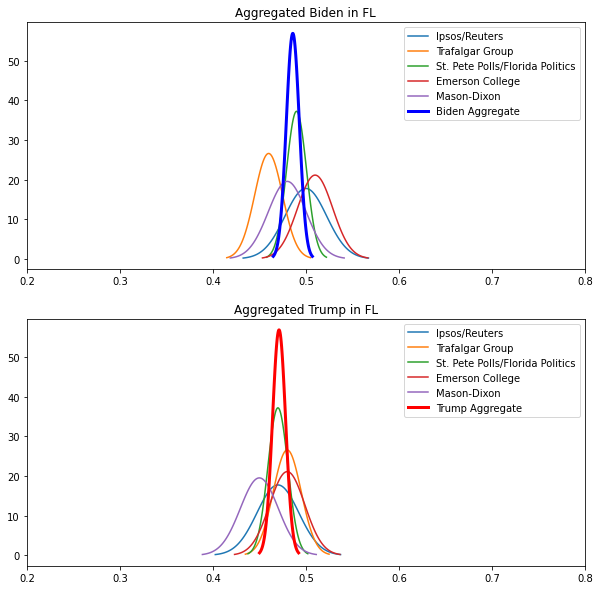

In [157]:
# poll plotter for every state
# latest five polls, with Trump and Biden aggregate distributions
for i in range(0, len(States)):
    State = States[i]

    StatePolls = df.loc[(df['State'] == State) & (df['MOE'] > 0)]
    qty_polls = min(len(StatePolls), QtyPolls)
    
    if qty_polls > 2:
        fig = plt.figure(figsize=(10,10))

        # latest Biden polls and Biden aggregate
        plt.subplot(2, 1, 1)
        plt.title('Aggregated Biden in ' + State)
        for j in range(0, qty_polls):
            biden_MU = StatePolls.iloc[j,6]
            sd = StatePolls.iloc[j,4] / 100 / 1.96
            x = np.linspace(biden_MU - 3*sd, biden_MU + 3*sd, 100)
            plt.plot(x, stats.norm.pdf(x, biden_MU, sd), label=StatePolls.iloc[j,1])

        # Biden aggregate poll
        b_mu_agg = Aggregates.iloc[i,1]
        sd_agg   = Aggregates.iloc[i,3]
        x = np.linspace(b_mu_agg - 3*sd_agg, b_mu_agg + 3*sd_agg, 100)
        plt.plot(x, stats.norm.pdf(x, b_mu_agg, sd_agg), label="Biden Aggregate", color='b', lw=3)

        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlim(.2,.8)

        # latest Trump polls and Trump aggregate
        plt.subplot(2, 1, 2)
        plt.title('Aggregated Trump in ' + State)
        for j in range(0, qty_polls):
            trump_MU = StatePolls.iloc[j,5]
            sd = StatePolls.iloc[j,4] / 100 / 1.96
            x = np.linspace(trump_MU - 3*sd, trump_MU + 3*sd, 100)
            plt.plot(x, stats.norm.pdf(x, trump_MU, sd), label=StatePolls.iloc[j,1])

        # Trump aggregate poll
        t_mu_agg = Aggregates.iloc[i,2]
        sd_agg   = Aggregates.iloc[i,3]
        x = np.linspace(t_mu_agg - 3*sd_agg, t_mu_agg + 3*sd_agg, 100)
        plt.plot(x, stats.norm.pdf(x, t_mu_agg, sd_agg), label="Trump Aggregate", color='r', lw=3)

        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlim(.2,.8)


        image_string = 'images_polls/' + State + '.png'
        fig.savefig(image_string, bbox_inches='tight')
        
        if State == 'FL':
            plt.show()
        
    plt.close()

In [145]:
# runs an instance of the national election, given mean and standard deviation per state
def NationalElection(Aggregates):
    BidenDelegates = 0
    TrumpDelegates = 0

    for i in range(0, len(Aggregates)):
        State = Aggregates.iloc[i,0]

        BidenResult = np.random.normal(Aggregates.iloc[i,1], Aggregates.iloc[i,3])
        TrumpResult = np.random.normal(Aggregates.iloc[i,2], Aggregates.iloc[i,3])

        if BidenResult > TrumpResult:
            BidenDelegates = BidenDelegates + EC[State]
        else:
            TrumpDelegates = TrumpDelegates + EC[State]

    return BidenDelegates, TrumpDelegates

In [146]:
# run 10,000 simulations of the national election using the aggregated polls
simulations = 10000
outcomes = pd.DataFrame(columns=('Biden','Trump'))

for i in range(0, simulations):
    outcomes = outcomes.reindex(outcomes.index.tolist() + list(range(outcomes.shape[0], outcomes.shape[0]+1)))
    biden, trump = NationalElection(Aggregates)
    outcomes.iloc[i, 0] = biden
    outcomes.iloc[i, 1] = trump

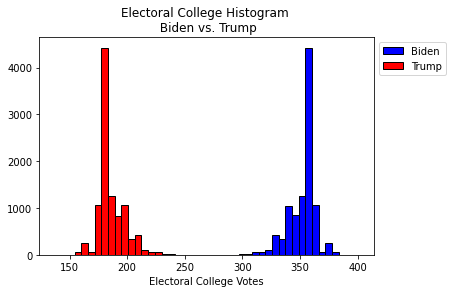

In [147]:
# plot histogram for outcomes of electoral college
plt.hist(outcomes['Biden'], color = 'blue', edgecolor = 'black', bins = 20, label = 'Biden')
plt.hist(outcomes['Trump'], color = 'red', edgecolor = 'black', bins = 20, label = 'Trump')
plt.title('Electoral College Histogram \n Biden vs. Trump')
plt.xlabel('Electoral College Votes')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('First Attempt Results.png', bbox_inches='tight')
plt.show()

This result does not illustrate sufficient uncertainty in the result of the election. The posterior distribution for each state yields a standard deviation that is likely too low in reality. 

# Second Attempt
Combine latest five poll samples into one weighted-average sample.  Sample sizes not large enough to bootstrap, use conservative MOE = 8%

In [161]:
# combine samples of latest five polls into one sample weighted-average
combined = pd.DataFrame(columns=('State','Biden','Trump', 'SD'))
MOE = 0.08
quantity_polls = 5

for i in range (0, len(States)):
    state = States[i]
    combined = combined.reindex(combined.index.tolist() + list(range(combined.shape[0], combined.shape[0]+1)))
    all_state_polls = df.loc[(df['State'] == state)]

    biden_size = 0
    trump_size = 0
    size = 0

    for j in range(0, min(len(all_state_polls), quantity_polls)):    
        trump_size = trump_size + all_state_polls.Trump.values[j]*float(all_state_polls.Size.values[j])
        biden_size = biden_size + all_state_polls.Biden.values[j]*float(all_state_polls.Size.values[j])
        size = size + float(all_state_polls.Size.values[j])

    combined.iloc[i,0] = state
    combined.iloc[i,1] = biden_size / size
    combined.iloc[i,2] = trump_size / size
    combined.iloc[i,3] = MOE / 1.96

In [162]:
# run 10,000 simulations of the national election using the combined sample
simulations = 10000
outcomes2 = pd.DataFrame(columns=('Biden','Trump'))

for i in range(0, simulations):
    outcomes2 = outcomes2.reindex(outcomes2.index.tolist() + list(range(outcomes2.shape[0], outcomes2.shape[0]+1)))
    biden, trump = NationalElection(combined)
    outcomes2.iloc[i, 0] = biden
    outcomes2.iloc[i, 1] = trump

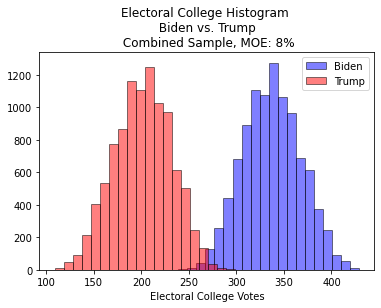

In [163]:
# plot histogram for outcomes of electoral college
plt.hist(outcomes2['Biden'], color='blue', edgecolor='black', bins=20, label='Biden', alpha=.5)
plt.hist(outcomes2['Trump'], color='red', edgecolor='black', bins=20, label='Trump', alpha=.5)
plt.title('Electoral College Histogram \n Biden vs. Trump \n Combined Sample, MOE: 8%')
plt.xlabel('Electoral College Votes')
plt.savefig('Second Attempt Results.png', bbox_inches='tight')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()